In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import random
from plot_lib import *
from ultralytics import YOLO
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.utils.ops import non_max_suppression as nms
from ultralytics.yolo.utils.ops import *

%matplotlib inline
%config InlineBackend.figure_format ="retina"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def set_seed(seed=1919810):
    random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed()

In [2]:
yolo_model = YOLO("weights/yolov8m-seg.pt")
yolo_model.to(device)
model = yolo_model.model
_ = model.eval()

In [3]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

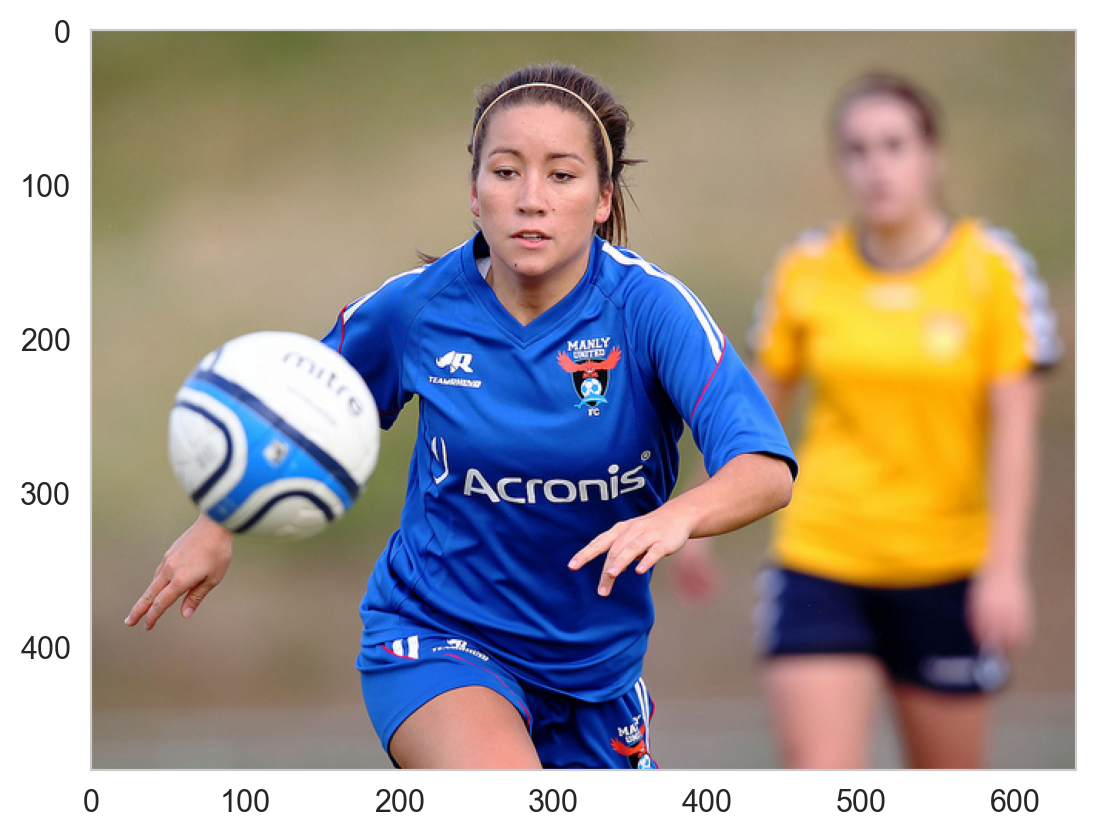

In [4]:
img = cv2.imread("coco-pictures/image2.jpg")[..., ::-1]
plot_single_image(img)

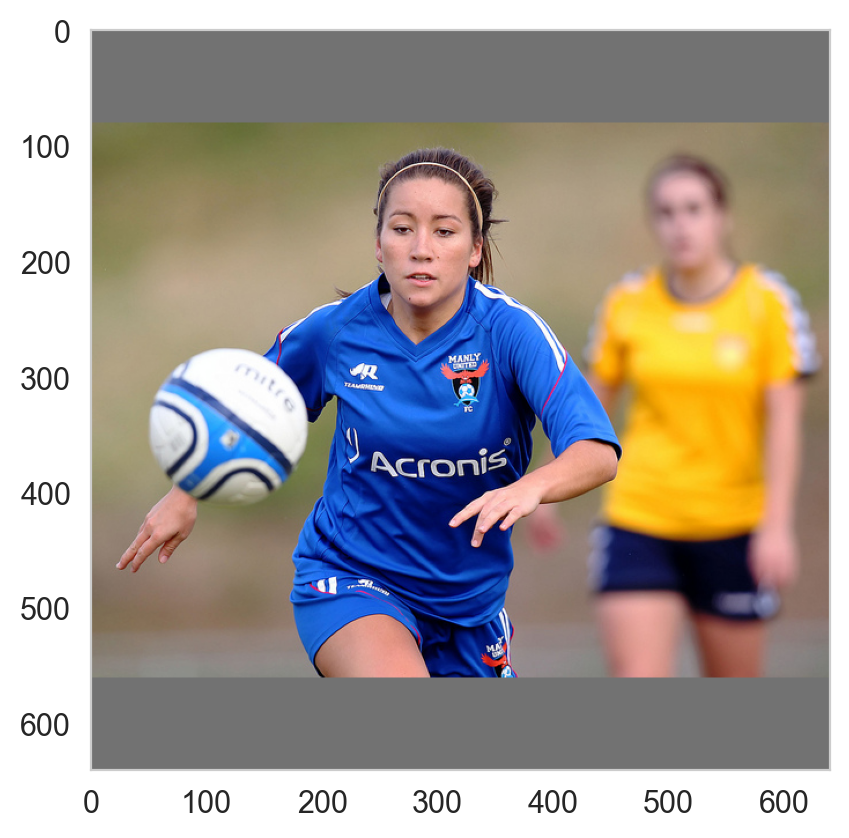

torch.Size([3, 640, 640])


In [5]:
conf_threshold = 0.25
img_size = yolo_model.overrides['imgsz']
stride = model.stride

letter_box = LetterBox(new_shape=img_size, stride=stride)
transform = transforms.Compose([
    transforms.ToTensor(),
])

input_img0 = letter_box(image=img)
plot_single_image(input_img0)

inputs = transform(input_img0)
print(inputs.shape)

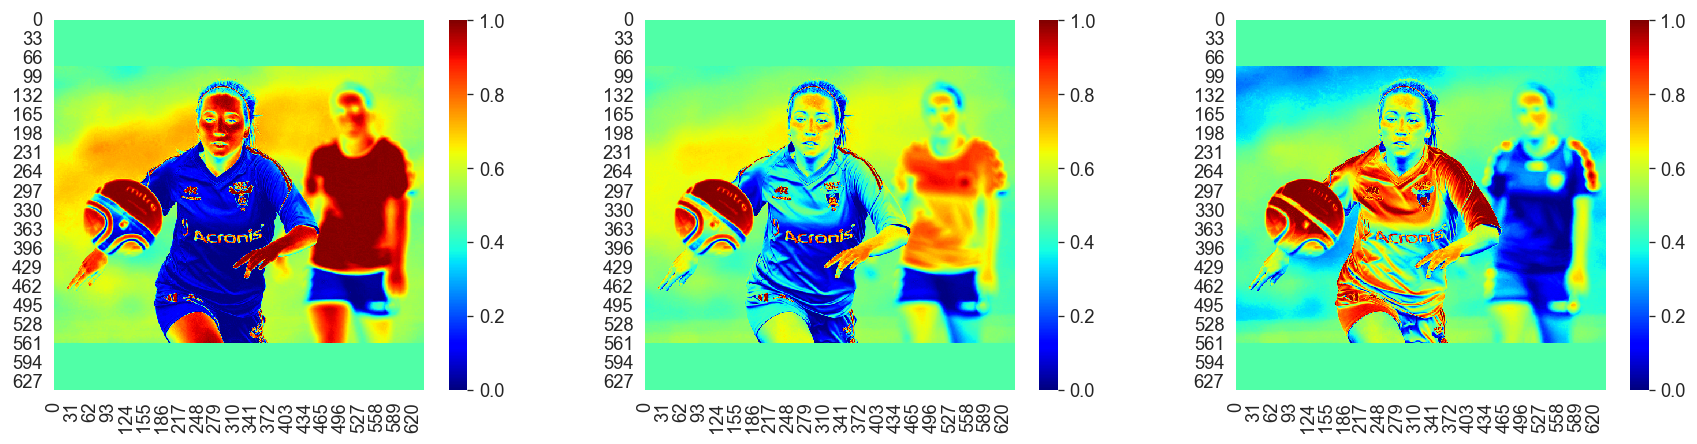

torch.Size([1, 3, 640, 640])


In [6]:
plot_multi_heatmaps(*inputs)
inputs = inputs.unsqueeze(0).to(device)
print(inputs.shape)

In [7]:
outputs = model(inputs)
print("Outputs 0:", outputs[0].shape)
print("Outputs [1][0][0]:", outputs[1][0][0].shape)
print("Outputs [1][0][1]:", outputs[1][0][1].shape)
print("Outputs [1][0][2]:", outputs[1][0][2].shape)
print("Outputs [1][1]:", outputs[1][1].shape)
print("Outputs [1][2]:", outputs[1][2].shape)

Outputs 0: torch.Size([1, 116, 8400])
Outputs [1][0][0]: torch.Size([1, 144, 80, 80])
Outputs [1][0][1]: torch.Size([1, 144, 40, 40])
Outputs [1][0][2]: torch.Size([1, 144, 20, 20])
Outputs [1][1]: torch.Size([1, 32, 8400])
Outputs [1][2]: torch.Size([1, 32, 160, 160])


In [8]:
# plot_multi_heatmaps(*outputs[1][2][0], col=4)
# plot_multi_heatmaps(*outputs[1][0][1][0, [0,1,2,3,60,61,62,63,96]])
# plot_multi_heatmaps(*outputs[1][0][2][0, [0,1,2,3,60,61,62,63,64]])

# 查看outputs[1][0]张量的有效内容（其中的中尺寸有球ind=64+32以及小尺寸的人ind=64+0）
由于绘图过程过于漫长，输出一次后使用md显示，此后不在运行，不然太慢了
```python
plot_multi_heatmaps(*outputs[1][0][1][0, [0,1,2,3,60,61,62,63,96]])
plot_multi_heatmaps(*outputs[1][0][2][0, [0,1,2,3,60,61,62,63,64]])
```
![](./docs/assets/seg-outputs.1.0.1.png)
![](./docs/assets/seg-outputs.1.0.2.png)
# 查看ouputs[1][2]张量(Mask的proto张量) （1x32x160x160）
由于绘图过程过于漫长，输出一次后使用md显示，此后不再运行
```python
plot_multi_heatmaps(*outputs[1][2][0], col=4)
```
得到输出：
![](./docs/assets/seg-outputs.1.2.png)

In [9]:
pred = outputs[0]
head_shapes = [80, 40, 20]
heads = []
start_i = 0
for i, p in enumerate(head_shapes):
    heads.append(pred[..., start_i:start_i+p**2].reshape(len(model.names)+36, p, p))
    start_i += p ** 2
print(*[i.shape for i in heads], sep="\n")

torch.Size([116, 80, 80])
torch.Size([116, 40, 40])
torch.Size([116, 20, 20])


# 张量描述
这个原理与YOLOACT是一模一样的，除了detect的nc:=80 + 4(xywh) == 84 外，还有32个channel为mask需要的proto张量等大小的张量，他还要与output[1][-1]的32个channel的proto共同计算得出mask。
output[1]的0与detect一模一样，1有啥用还不知道。

先忙到这里，后面不知道怎么算，下班！！